In [1]:
# EWMA transfers based FTS QUEUE time prediction

In [2]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### RSE 2 SITE mapping and data retrieving

In [3]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

In [1]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

NameError: name 'Elasticsearch' is not defined

## Make prediction using best window size

In [4]:
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s

In [52]:
src = 'BNL-ATLAS'
dst = 'CERN-PROD'
act = 'Production Input'
cut = data.where(data.LINK == '%s__%s__%s'%(src,dst,act)).dropna()
cut = cut.sort_values(by='SUBMITTED')
qt = np.append(np.zeros(1), cut.Q_TIME.values)
cut = cut.set_index(pd.to_datetime(cut.SUBMITTED, unit='s'))

39385


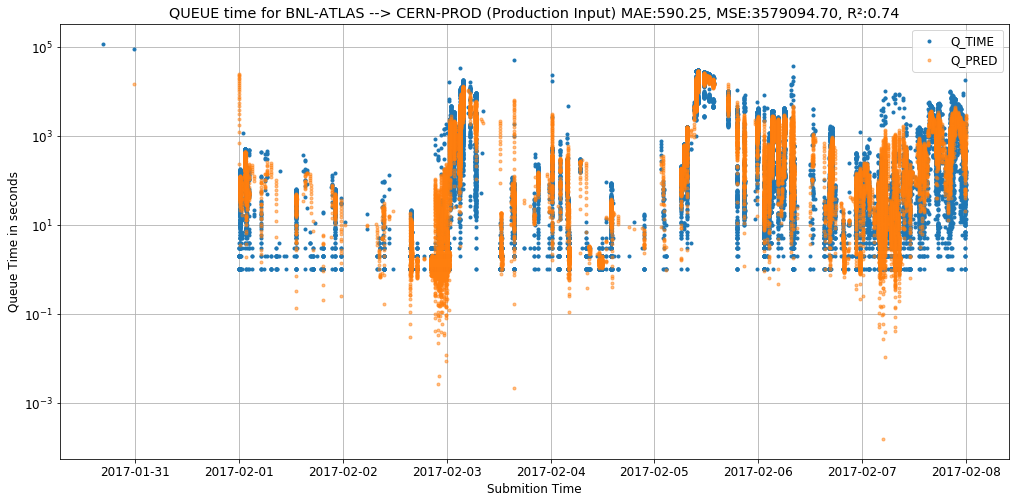

In [53]:
cut['Q_PRED'] = holt_winters_second_order_ewma(qt, 15, 0.07)[:-1]
#cut['Q_PRED'] = cut.Q_TIME.ewm(span=5,alpha=0.3).mean()
plt.plot(cut.index, cut.Q_TIME,'.')
plt.plot(cut.index, cut.Q_PRED, '.', alpha=0.5)
print(len(cut))
#s.expanding().mean()
n_mae = mae(cut.Q_TIME, cut.Q_PRED)
n_mse = mse(cut.Q_TIME, cut.Q_PRED)
n_r2 = r2(cut.Q_TIME, cut.Q_PRED)
plt.title('QUEUE time for %s --> %s (%s) MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(src, dst, act,n_mae, n_mse,n_r2))
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submition Time')
plt.ylabel('Queue Time in seconds')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

## Trying all the window sizes

In [55]:
cut = data.where(data.LINK == '%s__%s__%s'%(src,dst,act)).dropna()
cut = cut.sort_values(by='SUBMITTED')
nr = np.append(np.zeros(1), cut.Q_TIME.values)
r2_scores = []
for winsize in range(1, 101, 1):
    cut['Q_PRED_%d'%winsize] = holt_winters_second_order_ewma(nr, winsize, 0.07)[:-1]
    r2_scores.append(r2(cut.Q_TIME, cut['Q_PRED_%d'%winsize]))

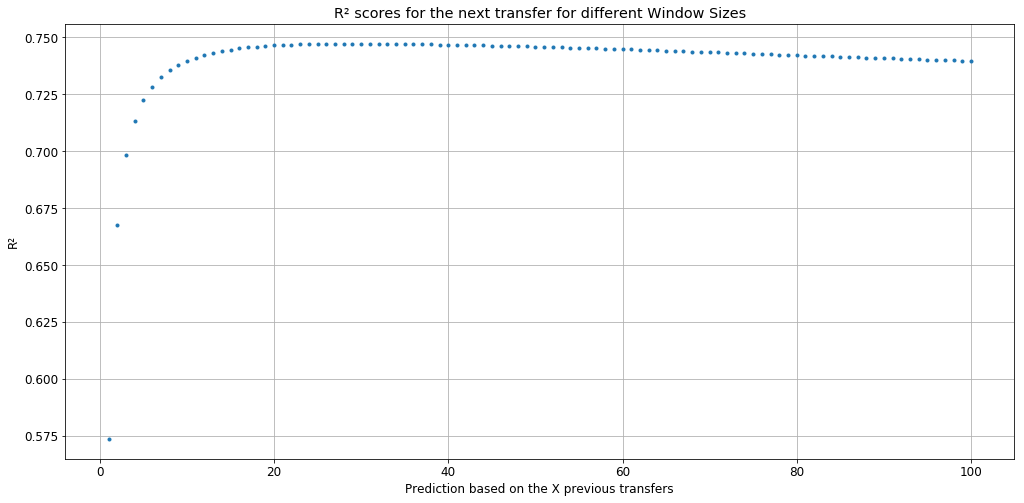

In [56]:
plt.plot(range(1,101),r2_scores, '.')
plt.title('R² scores for the next transfer for different Window Sizes')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Prediction based on the X previous transfers')
plt.ylabel('R²')

fig = plt.gcf()
fig.set_size_inches(17, 8)
#plt.legend()
plt.grid()
plt.show()